In [32]:
import h5py

# Hierarchical File Format (Section 3.6)

The dataset file "dataset.h5" is a hdf5 file that has the following hierarchical structure:

![h5 structure](media/structure.drawio.png)


## Accessing data in Python

In [1]:
data_path = # Your data path to dataset.h5

In [28]:
with h5py.File(data_path, "r") as data:
    print(f"Data file type: {type(data)}")s
    print(f"Keys: {data.keys()}")
    print()
    print(f"e.g., type of data['train']: {type(data['train'])}")
    print(f"data['train'].keys(): {data['train'].keys()}")
    print()
    print(f"Access labels by data['train']['labels'].keys(): { data['train']['labels'].keys()}")
    print(f"e.g. data['train']['labels']['viticulture'].shape: { data['train']['labels']['viticulture'].shape}")
    print()
    print(f"Access Sentinel-2 time series by data['train']['sentinel2'].keys(): { data['train']['sentinel2'].keys()}")
    print(f"e.g. data['train']['sentinel2']['05_may_2019'].shape: { data['train']['sentinel2']['05_may_2019'].shape}")

Data file type: <class 'h5py._hl.files.File'>
Keys: <KeysViewHDF5 ['test', 'train', 'val']>

e.g., type of data['train']: <class 'h5py._hl.group.Group'>
data['train'].keys(): <KeysViewHDF5 ['labels', 'sentinel2']>

Access labels by data['train']['labels'].keys(): <KeysViewHDF5 ['field', 'market', 'viticulture']>
e.g. data['train']['labels']['viticulture'].shape: (7095, 128, 128, 5)

Access Sentinel-2 time series by data['train']['sentinel2'].keys(): <KeysViewHDF5 ['01_january_2019', '02_february_2019', '03_march_2019', '04_april_2019', '05_may_2019', '06_june_2019', '07_july_2019', '08_august_2019', '09_september_2019', '10_october_2019', '12_december_2019']>
e.g. data['train']['sentinel2']['05_may_2019'].shape: (7095, 10, 128, 128)


**NB: using the syntax:**
```python
with h5py.File(data_path, "r") as data:
    ...
```
**is equivalent to:**
```python
data = h5py.File(data_path, "r")
...
data.close()
```
**However always prefer the first syntax as it closes the file automatically and prevents wasting memory**

## Let's visualize data !

### By starting with Sentinel-2 images

Let's take a random timestamp of a random image from - let's say - the train subset and display its Sentinel-2 bands to see what they look like.

In the example below, we consider a random image of June.

In [146]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

import numpy as np

def plot_bands(some_image, band_names):
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(10):
        ax = axes[i]
        im = ax.imshow(some_image[i], cmap='viridis')
        ax.set_title(band_names[i])
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    for j in range(10, 12):
        axes[j].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0.12)
    plt.show()

def get_rgb(some_image):
    red = some_image[2]
    green = some_image[1]
    blue =  some_image[0]
    rgb_image = np.dstack([red, green, blue])
    return rgb_image
    
def plot_rgb(some_image, title):
    rgb_image = get_rgb(some_image)
    plt.imshow(rgb_image)
    plt.title(title)
    plt.show()

def plot_timestamps(data, image_idx):
    timestamp_keys =  data["train"]["sentinel2"].keys()
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    axes = axes.flatten()

    for i, timestamp in enumerate(timestamp_keys):
        ax = axes[i]
        some_image = data["train"]["sentinel2"][timestamp][image_idx]
        rgb_image = get_rgb(some_image)
        im = ax.imshow(rgb_image)
        ax.set_title(timestamp)
        ax.axis('off')

    for j in range(10, 12):
        axes[j].axis('off')
    
    plt.subplots_adjust(wspace=-0.1, hspace=0.12)
    plt.show()

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'black']
legend = ['Very low', 'Low', 'Average', 'High', 'Very high', 'Unlabeled']

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
norm = Normalize(vmin=0, vmax=5)

band_names = [
    "B02 (Blue 490nm)", 
    "B03 (Green 560nm)", 
    "B04 (Red 665nm)", 
    "B05 (NIR 705nm)", 
    "B06 (NIR 740nm)",
    "B07 (NIR 783nm)", 
    "B08 (NIR 842nm)",
    "B8A (NIR 865nm)",
    "B11 (SWIR 1610nm)", 
    "B12 (SWIR 2190nm)"
]
june_timestamp = "06_june_2019"
image_idx = 5555

crop_types = ["viticulture", "market", "field"]


In [147]:
with h5py.File(data_path, "r") as data:
    some_image = data["train"]["sentinel2"][june_timestamp][image_idx]
    print(some_image.shape, type(some_image))
    print()
    print("Band stats:")
    for i_band in range(10):
        some_band = some_image[i_band]
        print(f"Band name: {band_names[i_band]}")
        print(f"Shape: {some_band.shape}")
        print(f"Max: {np.max(some_band):.4f} Min: {np.min(some_band):.4f}")
        print(f"Mean: {np.mean(some_band):.4f} Std-dev: {np.std(some_band):.4f}")
        print()
        break # You get the idea, remove if you want to see all bands

(10, 128, 128) <class 'numpy.ndarray'>

Band stats:
Band name: B02 (Blue 490nm)
Shape: (128, 128)
Max: 1.0000 Min: 0.0612
Mean: 0.2192 Std-dev: 0.1178



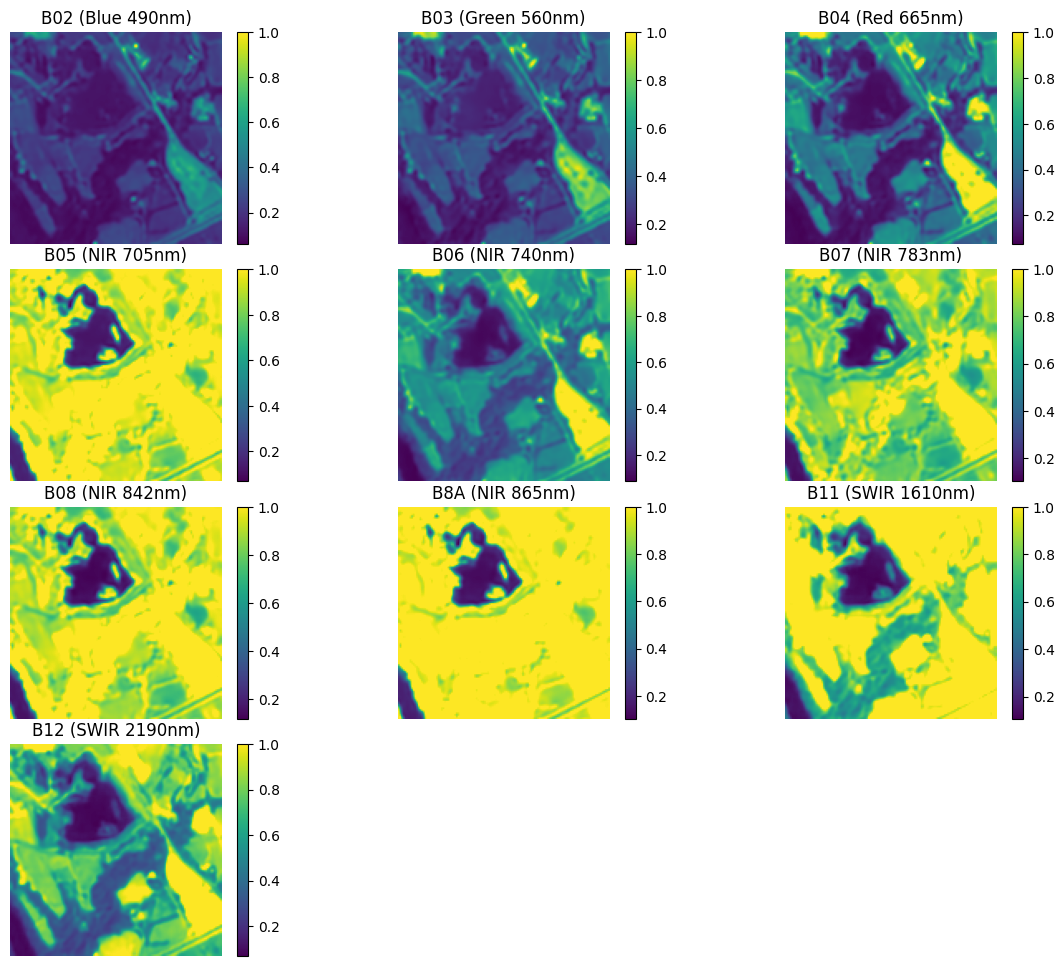

In [148]:
with h5py.File(data_path, "r") as data:
    some_image = data["train"]["sentinel2"][june_timestamp][image_idx]
    plot_bands(some_image, band_names)

### Those were the individual bands of Sentinel-2, under a heatmap or grayscale format... 
### Now, let's make a color image so we can better understand the scene

A color image consists of bringing together the Red, the Green, and the Blue bands to form an RGB image

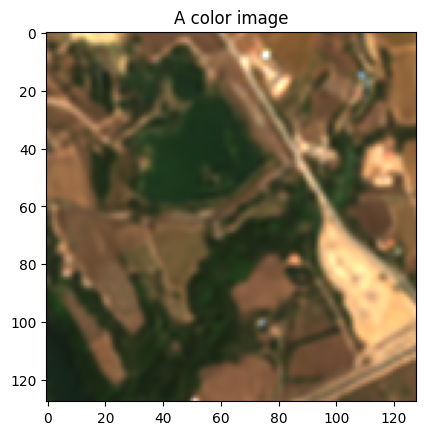

In [149]:
with h5py.File(data_path, "r") as data:
    some_image = data["train"]["sentinel2"][june_timestamp][image_idx]
    plot_rgb(some_image, "A color image")

### Now let's see how the same scene (same place) looks like across different months

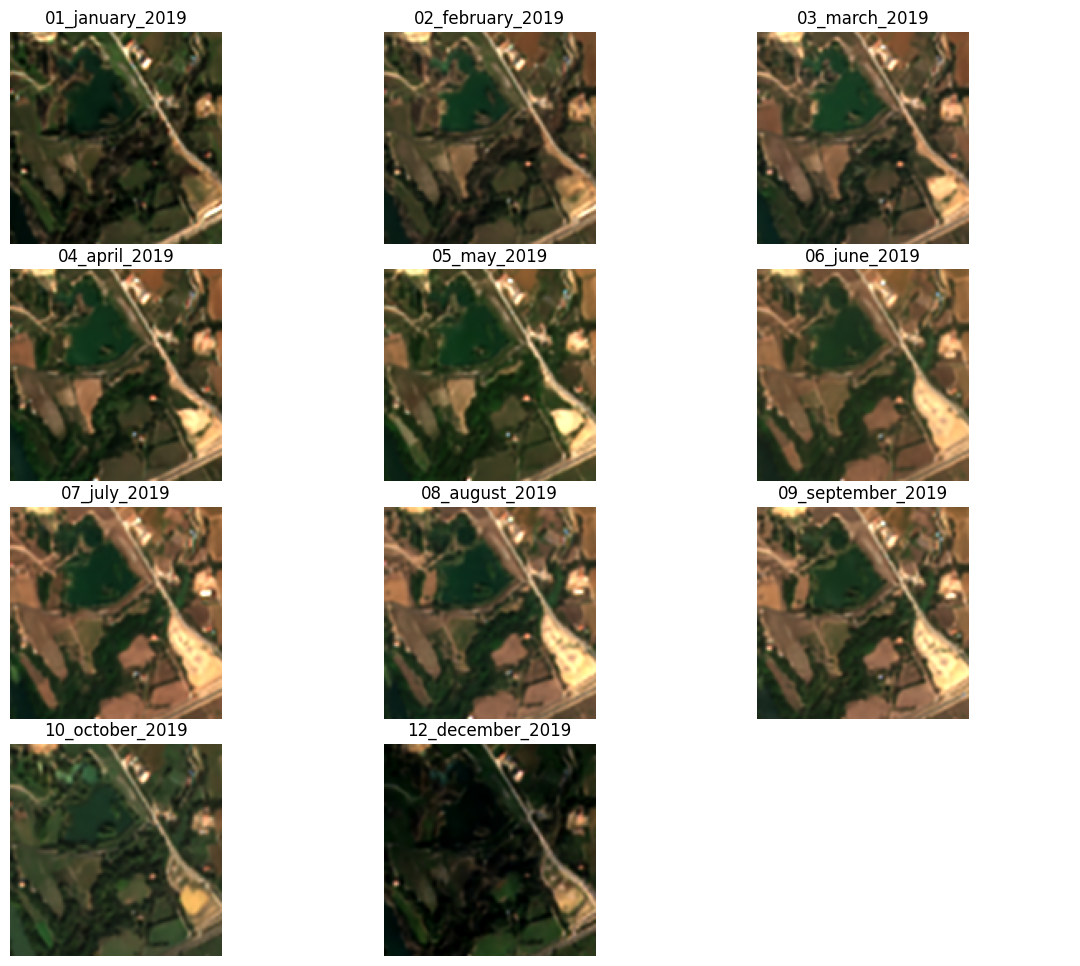

In [150]:
with h5py.File(data_path, "r") as data:
    plot_timestamps(data, image_idx)


## Let's now visualize the labels (agricultural potentials)

### There are 5 potential levels for 3 crop types, let's visualize them for the above image

Labels are encoded in one-hot format. In order to display them, we should map them to a 1D array.  
**Do not forget that there is a special ignore label (0,0,0,0,0) for unlabeled pixels**

(128, 128, 5)


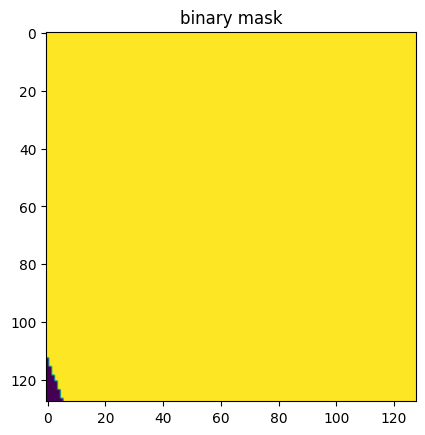

In [151]:
with h5py.File(data_path, "r") as data:
    
    some_label = data["train"]["labels"]["viticulture"][image_idx]
    print(some_label.shape) # one-hot

    # Get a binary mask for labeled pixels
    binary_mask = np.sum(some_label, axis=-1)

    plt.imshow(binary_mask)
    plt.title("binary mask")
    plt.show()


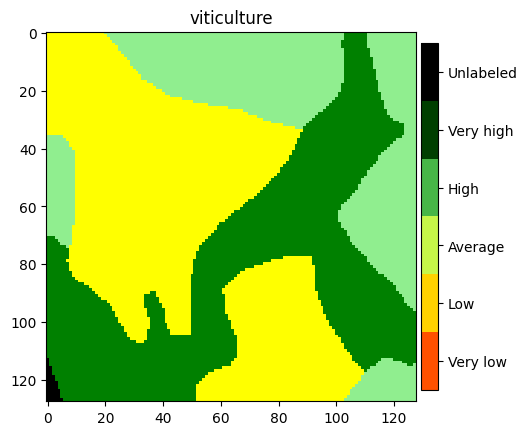

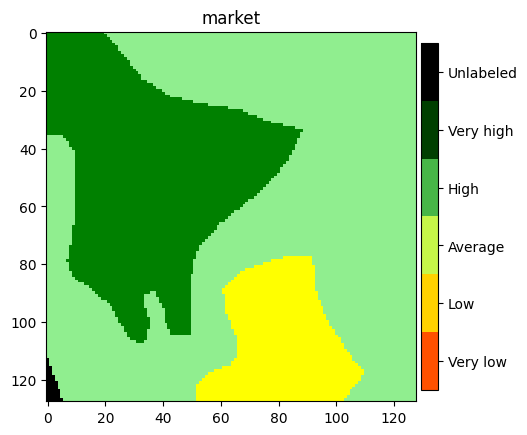

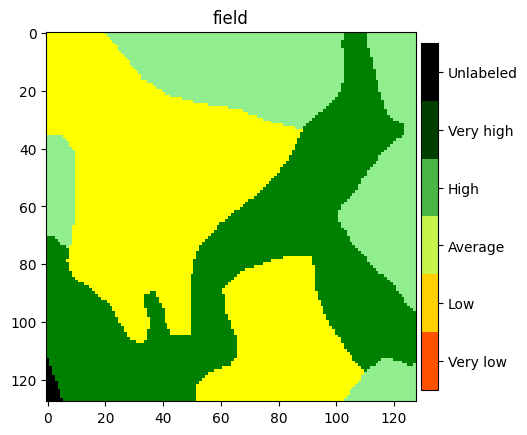

In [152]:
with h5py.File(data_path, "r") as data:
    for crop_type in crop_types:
        some_label = data["train"]["labels"][crop_type][image_idx]
        
        # Now get the classes and apply the mask
        x = np.argmax(some_label, axis=-1)
        x[binary_mask == 0] = 6
        
        im = plt.imshow(x, cmap=cmap, norm=norm, interpolation="nearest")
        cbar = plt.colorbar(im, 
                        fraction=0.035, 
                        pad=0.01, 
                        ticks=np.arange(0.5, 6.0), 
                        boundaries=np.arange(0, 7), 
                        extend='neither')
        cbar.ax.set_yticklabels(legend)
        plt.title(crop_type)
        plt.show()

## You reached the end. This is all you need to know on how to access and manipulate the data.
## In another tutorial, we will see how to make a flexible Pytorch dataloader 